In [33]:
from architecture import ConvNetBuilder
from utils import train_network, test_network, get_soft_labels, generate_noise_dataloader
from dataset import MNISTDataLoader
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [11]:
def visualize_img(tensor):

    image_tenor = tensor * 0.5 + 0.5
    numpy_image = image_tenor.numpy()
    plt.imshow(numpy_image[0], cmap='gray')
    plt.show()


In [6]:
# setting a fixed seed
seed_value = 19
BATCH_SIZE = 4

torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:

student_input_dict = { "size": [16, 32], "kernel_size": [3, 3], "stride": [1, 1], "padding": [0, 0], "dropout": [0, 0] }

student0 = ConvNetBuilder(1, 10, student_input_dict) # learns from softlabeled noise
student1 = ConvNetBuilder(1, 10, student_input_dict) # learns from hardlabeled mnist
student2 = ConvNetBuilder(1, 10, student_input_dict) # learns from softlabeled mnist
student3 = ConvNetBuilder(1, 10, student_input_dict) # no learning / random baseline

student0.to(device)
student1.to(device)
student2.to(device)
student3.to(device)

teacher_input_dict = { "size": [16, 32, 64, 64], "kernel_size": [3, 3, 3, 3], "stride": [1, 1, 1, 1], "padding": [1, 1, 1, 1], "dropout": [0.5, 0.5, 0.5, 0.5] }
teacher = ConvNetBuilder(1, 10, teacher_input_dict)

teacher.to(device)

ConvNetBuilder(
  (conv_blocks): ModuleList(
    (0): ConvBlock(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (3): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [ ]:
trainloader, testloader = MNISTDataLoader(BATCH_SIZE).load_data()
teacher = train_network(teacher, trainloader, 1, 0.001, device)

print("finished training teacher")

In [4]:
test_network(teacher, testloader, device)

Accuracy of the network on the 10000 test images: 95 %


0.9528

In [5]:
mnist_soft_labels_loader = get_soft_labels(teacher, trainloader, device)
print("finished getting soft labels for MNIST")

# mnist dataset has 60k images, for the noise we will generate 600k images
noise_loader = generate_noise_dataloader(600000, device, BATCH_SIZE)
noise_soft_labels_loader = get_soft_labels(teacher, noise_loader, device)
print("finished getting soft labels for noise")


finished getting soft labels for MNIST
finished getting soft labels for noise


labels:  tensor(2)


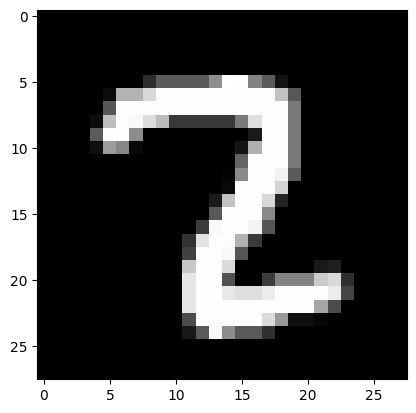

In [24]:
# lets plot a couple of images from the noise dataset along with their lables
j = 1
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to("cpu"), labels.to("cpu")
    print("labels: ", labels[j])

    visualize_img(inputs[j])
    break

In [32]:
for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = teacher(inputs)

    print("outputs: ", outputs)
    print("labels: ", labels)
    break

outputs:  tensor([[-2.9868, -1.4777, -2.2631, -0.9121, -0.2898, -2.4742, -4.5442, -1.1506,
          0.6245,  1.3596],
        [-2.5458, -1.9187, -3.9376,  0.1694, -3.8364,  2.1696, -1.3981, -3.2794,
         -0.7074, -1.0538],
        [-1.5826,  2.2977, -1.0924, -2.1522, -0.6971, -1.9591, -0.2805, -2.7371,
          0.6655, -2.1376],
        [-2.3332,  2.6288, -1.6683, -1.7244, -0.3024, -2.2090, -1.1243, -2.0134,
          0.3028, -1.3705]], device='cuda:0', grad_fn=<AddmmBackward0>)
labels:  tensor([9, 5, 1, 1], device='cuda:0')


In [42]:
criterion = nn.CrossEntropyLoss()

b_output = torch.tensor([[-2.9868, -1.4777, -2.2631, -0.9121, -0.2898, -2.4742, -4.5442, -1.1506, 0.6245,  1.3596]])
b_label = torch.tensor([8])

print(criterion(b_output, b_label)) 
print(criterion(b_label, b_output))
# print(criterion(b_label, b_label2))
b_label2 = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0.999999, 0]])


tensor(1.4175)


RuntimeError: "log_softmax_lastdim_kernel_impl" not implemented for 'Long'

In [17]:
student0 = train_network(student0, noise_soft_labels_loader, 1, 0.001, device)

print("evaluating student 0 which is trained on soft labels from noise")
test_network(student0, testloader, device)

[1,   100] loss: 1.309
[1,   200] loss: 1.264
[1,   300] loss: 1.237
[1,   400] loss: 1.218
[1,   500] loss: 1.207
[1,   600] loss: 1.201
[1,   700] loss: 1.215
[1,   800] loss: 1.214
[1,   900] loss: 1.200
[1,  1000] loss: 1.219
[1,  1100] loss: 1.204
[1,  1200] loss: 1.200
[1,  1300] loss: 1.203
[1,  1400] loss: 1.202
[1,  1500] loss: 1.203
[1,  1600] loss: 1.214
[1,  1700] loss: 1.206
[1,  1800] loss: 1.190
[1,  1900] loss: 1.190
[1,  2000] loss: 1.179
[1,  2100] loss: 1.200
[1,  2200] loss: 1.205
[1,  2300] loss: 1.205
[1,  2400] loss: 1.177
[1,  2500] loss: 1.205
[1,  2600] loss: 1.188
[1,  2700] loss: 1.202
[1,  2800] loss: 1.180
[1,  2900] loss: 1.167
[1,  3000] loss: 1.189
[1,  3100] loss: 1.188
[1,  3200] loss: 1.176
[1,  3300] loss: 1.175
[1,  3400] loss: 1.188
[1,  3500] loss: 1.173
[1,  3600] loss: 1.178
[1,  3700] loss: 1.168
[1,  3800] loss: 1.175
[1,  3900] loss: 1.172
[1,  4000] loss: 1.177
[1,  4100] loss: 1.178
[1,  4200] loss: 1.183
[1,  4300] loss: 1.167
[1,  4400] 

0.1891

In [ ]:
student1 = train_network(student1, trainloader, 1, 0.001, device)

print("evaluating student 1 which is trained on hard labels")
test_network(student1, testloader, device)

In [25]:
student2 = train_network(student2, mnist_soft_labels_loader, 1, 0.001, device)

print("evaluating student 2 which is trained on soft labels")
test_network(student2, testloader, device)

[1,   100] loss: 1.701
[1,   200] loss: 1.242
[1,   300] loss: 1.255
[1,   400] loss: 1.231
[1,   500] loss: 1.225
[1,   600] loss: 1.234
[1,   700] loss: 1.246
[1,   800] loss: 1.197
[1,   900] loss: 1.208
[1,  1000] loss: 1.202
[1,  1100] loss: 1.186
[1,  1200] loss: 1.168
[1,  1300] loss: 1.179
[1,  1400] loss: 1.205
[1,  1500] loss: 1.144
[1,  1600] loss: 1.174
[1,  1700] loss: 1.183
[1,  1800] loss: 1.167
[1,  1900] loss: 1.173
[1,  2000] loss: 1.180
[1,  2100] loss: 1.119
[1,  2200] loss: 1.181
[1,  2300] loss: 1.195
[1,  2400] loss: 1.135
[1,  2500] loss: 1.163
[1,  2600] loss: 1.163
[1,  2700] loss: 1.214
[1,  2800] loss: 1.184
[1,  2900] loss: 1.118
[1,  3000] loss: 1.161
[1,  3100] loss: 1.140
[1,  3200] loss: 1.153
[1,  3300] loss: 1.198
[1,  3400] loss: 1.205
[1,  3500] loss: 1.158
[1,  3600] loss: 1.165
[1,  3700] loss: 1.198
[1,  3800] loss: 1.115
[1,  3900] loss: 1.149
[1,  4000] loss: 1.192
[1,  4100] loss: 1.164
[1,  4200] loss: 1.178
[1,  4300] loss: 1.132
[1,  4400] 

0.9062

In [ ]:
print("evaluating student 3 which is not trained yet")
test_network(student3, testloader, device)